In [1]:
import os
from PIL import Image, ImageFile
import math
import copy
ImageFile.LOAD_TRUNCATED_IMAGES = True
from transformers import CLIPProcessor, CLIPModel
import pandas as pd
import torch
import matplotlib.pyplot as plt
import numpy as np

/Users/pongkornsettasompop/anaconda3/envs/mi/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import open_clip

model_name = 'coca_ViT-L-14' #'ViT-L-14-CLIPA'
pretrained = 'mscoco_finetuned_laion2b_s13b_b90k' #'datacomp1b'
device = "cuda" if torch.cuda.is_available() else "cpu"
model, _, preprocess = open_clip.create_model_and_transforms(model_name,
                                                             device = device,
                                                             pretrained=pretrained)

In [3]:
print(preprocess)

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=warn)
    CenterCrop(size=(224, 224))
    <function _convert_to_rgb at 0x1790c79a0>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)


In [4]:
open_clip.list_pretrained()

[('RN50', 'openai'),
 ('RN50', 'yfcc15m'),
 ('RN50', 'cc12m'),
 ('RN50-quickgelu', 'openai'),
 ('RN50-quickgelu', 'yfcc15m'),
 ('RN50-quickgelu', 'cc12m'),
 ('RN101', 'openai'),
 ('RN101', 'yfcc15m'),
 ('RN101-quickgelu', 'openai'),
 ('RN101-quickgelu', 'yfcc15m'),
 ('RN50x4', 'openai'),
 ('RN50x16', 'openai'),
 ('RN50x64', 'openai'),
 ('ViT-B-32', 'openai'),
 ('ViT-B-32', 'laion400m_e31'),
 ('ViT-B-32', 'laion400m_e32'),
 ('ViT-B-32', 'laion2b_e16'),
 ('ViT-B-32', 'laion2b_s34b_b79k'),
 ('ViT-B-32', 'datacomp_xl_s13b_b90k'),
 ('ViT-B-32', 'datacomp_m_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_clip_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_laion_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_image_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_text_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_basic_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_s128m_b4k'),
 ('ViT-B-32', 'datacomp_s_s13m_b4k'),
 ('ViT-B-32', 'commonpool_s_clip_s13m_b4k'),
 ('ViT-B-32', 'commonpool_s_laion_s13m_b4k'),
 ('ViT-B-32', 'commonpool_

In [5]:
base_dir = './dataset/'
src_dir = base_dir + '/test_tran'
query_dir = base_dir + '/queries'
submission = pd.read_csv(base_dir+ '/sample_submission.csv')

In [6]:

import os
from PIL import Image
import torchvision.transforms as transforms
import torch
from torchvision.transforms import Resize, CenterCrop, Pad, Compose
import torchvision.transforms.functional as F


query_classes = []
q_batch =  []
print(preprocess)
# Define transforms for each augmentation
preprocess_original = preprocess  # Your original preprocess function for clear RGB images
preprocess_grayscale = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    preprocess
])
preprocess_blur = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.GaussianBlur(5, sigma=(0.1, 2.0)),
    preprocess
])
preprocess_zoom_out = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    # Step 1: Resize the image to make it smaller than the model's expected input dimensions
    transforms.Resize(180),  # Assuming the original input size is 256x256, adjust this value as needed
    # Step 2: Pad the resized image to match the model's expected input dimensions
    # The padding mode can be changed as needed (e.g., 'constant', 'edge', 'reflect')
    lambda img: F.pad(img, padding=(38, 38, 38, 38), padding_mode='constant', fill=0),
    # Step 3: Apply your model-specific preprocessing (e.g., normalization)
    preprocess
])
preprocess_sharpness = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.ColorJitter(contrast=(1,2)),
    preprocess
])

preprocess_affine1 = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomAffine(degrees=(0, 90), scale=(0.5, 0.9)),
    preprocess
])

gray = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    ])

augmentations = {
    'rotation': transforms.Compose([transforms.RandomRotation(degrees=(0,90))]),
    'rotation2': transforms.Compose([transforms.RandomRotation(degrees=(270,360))]),
    'affine': transforms.Compose([ transforms.RandomAffine(degrees=(0, 90), scale=(0.5, 0.9))]),
    'affine2': transforms.Compose([ transforms.RandomAffine(degrees=(270, 360), scale=(0.5, 0.9))]),
    'sharpness': transforms.Compose([transforms.RandomAdjustSharpness(40)]),
    'contrast': transforms.Compose([transforms.ColorJitter(contrast=(1,2))]),
}


for file in os.listdir(query_dir):
    print(file)
    class_id = int(file[:-5])  # Assuming the class ID is in the filename
    count = 0    
    # Load image
    img_path = os.path.join(query_dir, file)
    image = Image.open(img_path).convert('RGB')
    # for augmentation_name, augmentation_transform in augmentations.items():
    #     combined_transform = transforms.Compose([gray,preprocess,augmentation_transform])
    #     print(combined_transform)
    #     q_batch.append(combined_transform(image))
    #     count += 1    
    # # Apply each augmentation and append to q_batch
    q_batch.append(preprocess_original(image))  # Original clear RGB image
    q_batch.append(preprocess_grayscale(image))  # Grayscale
    q_batch.append(preprocess_blur(image))  # Blurred
    q_batch.append(preprocess_zoom_out(image))
    #q_batch.append(preprocess_sharpness(image))#zoom-out
    #q_batch.append(preprocess_affine1(image))
    count = count + 4
    # Replicate class ID for each augmented image version
    query_classes.extend([class_id] * count)# 4 versions of each image
    print(query_classes)

# Stack all processed images into a tensor
q_batch_transformed = torch.stack(q_batch, dim=0).to(device)

print(q_batch_transformed.shape)  # Check the shape, should be 4x larger in the first dimension

# Generate embeddings
with torch.no_grad():
    q_embeddings = model.encode_image(q_batch_transformed).cpu()
    q_embeddings /= q_embeddings.norm(dim=-1, keepdim=True)
#torch.save(model.state_dict(), 'openclip_test.pth')
print(q_embeddings.shape)

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=warn)
    CenterCrop(size=(224, 224))
    <function _convert_to_rgb at 0x1790c79a0>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)
10.jpeg
[10, 10, 10, 10]
1.jpeg
[10, 10, 10, 10, 1, 1, 1, 1]
11.jpeg


/Users/pongkornsettasompop/anaconda3/envs/mi/lib/python3.10/site-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[10, 10, 10, 10, 1, 1, 1, 1, 11, 11, 11, 11]
16.jpeg
[10, 10, 10, 10, 1, 1, 1, 1, 11, 11, 11, 11, 16, 16, 16, 16]
6.jpeg
[10, 10, 10, 10, 1, 1, 1, 1, 11, 11, 11, 11, 16, 16, 16, 16, 6, 6, 6, 6]
7.jpeg
[10, 10, 10, 10, 1, 1, 1, 1, 11, 11, 11, 11, 16, 16, 16, 16, 6, 6, 6, 6, 7, 7, 7, 7]
17.jpeg
[10, 10, 10, 10, 1, 1, 1, 1, 11, 11, 11, 11, 16, 16, 16, 16, 6, 6, 6, 6, 7, 7, 7, 7, 17, 17, 17, 17]
8.jpeg
[10, 10, 10, 10, 1, 1, 1, 1, 11, 11, 11, 11, 16, 16, 16, 16, 6, 6, 6, 6, 7, 7, 7, 7, 17, 17, 17, 17, 8, 8, 8, 8]
18.jpeg
[10, 10, 10, 10, 1, 1, 1, 1, 11, 11, 11, 11, 16, 16, 16, 16, 6, 6, 6, 6, 7, 7, 7, 7, 17, 17, 17, 17, 8, 8, 8, 8, 18, 18, 18, 18]
4.jpeg
[10, 10, 10, 10, 1, 1, 1, 1, 11, 11, 11, 11, 16, 16, 16, 16, 6, 6, 6, 6, 7, 7, 7, 7, 17, 17, 17, 17, 8, 8, 8, 8, 18, 18, 18, 18, 4, 4, 4, 4]
14.jpeg
[10, 10, 10, 10, 1, 1, 1, 1, 11, 11, 11, 11, 16, 16, 16, 16, 6, 6, 6, 6, 7, 7, 7, 7, 17, 17, 17, 17, 8, 8, 8, 8, 18, 18, 18, 18, 4, 4, 4, 4, 14, 14, 14, 14]
15.jpeg
[10, 10, 10, 10, 1, 1, 1, 1

tensor([[0.0127, 0.0130, 0.0130, 0.0123, 0.0179, 0.0181, 0.0178, 0.0179, 0.0128,
         0.0130, 0.0130, 0.0125, 0.0131, 0.0133, 0.0129, 0.0126, 0.0122, 0.0122,
         0.0121, 0.0118, 0.0118, 0.0118, 0.0119, 0.0118, 0.0130, 0.0127, 0.0127,
         0.0123, 0.0118, 0.0120, 0.0120, 0.0120, 0.0138, 0.0138, 0.0138, 0.0135,
         0.0126, 0.0126, 0.0125, 0.0125, 0.0137, 0.0141, 0.0140, 0.0135, 0.0130,
         0.0135, 0.0135, 0.0132, 0.0119, 0.0120, 0.0122, 0.0123, 0.0127, 0.0129,
         0.0128, 0.0123, 0.0129, 0.0129, 0.0128, 0.0126, 0.0164, 0.0168, 0.0164,
         0.0161, 0.0124, 0.0130, 0.0125, 0.0123, 0.0133, 0.0133, 0.0133, 0.0129,
         0.0121, 0.0120, 0.0117, 0.0116]])
tensor(0.0181)


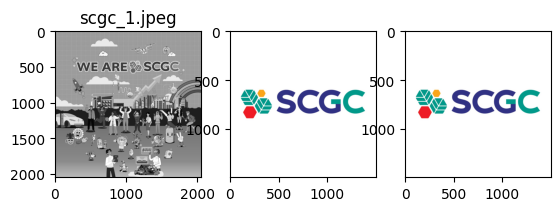

/var/folders/qc/p47pk0895gqf_sgg3vgy46g40000gn/T/ipykernel_53917/2311969795.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['class'] = submission['Predicted']


tensor([[0.0130, 0.0133, 0.0133, 0.0127, 0.0158, 0.0160, 0.0158, 0.0162, 0.0131,
         0.0134, 0.0134, 0.0130, 0.0127, 0.0129, 0.0126, 0.0124, 0.0131, 0.0131,
         0.0131, 0.0127, 0.0115, 0.0115, 0.0116, 0.0115, 0.0132, 0.0133, 0.0133,
         0.0129, 0.0114, 0.0116, 0.0116, 0.0116, 0.0142, 0.0143, 0.0143, 0.0140,
         0.0123, 0.0124, 0.0124, 0.0122, 0.0134, 0.0137, 0.0137, 0.0131, 0.0129,
         0.0133, 0.0133, 0.0130, 0.0123, 0.0123, 0.0126, 0.0126, 0.0143, 0.0147,
         0.0146, 0.0140, 0.0140, 0.0140, 0.0138, 0.0136, 0.0149, 0.0155, 0.0151,
         0.0151, 0.0116, 0.0122, 0.0119, 0.0119, 0.0134, 0.0133, 0.0133, 0.0129,
         0.0122, 0.0119, 0.0116, 0.0117]])
tensor(0.0162)


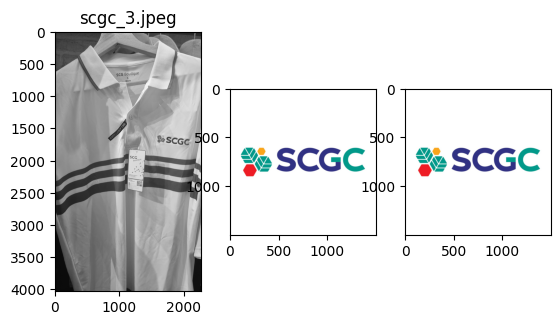

/var/folders/qc/p47pk0895gqf_sgg3vgy46g40000gn/T/ipykernel_53917/2311969795.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['class'] = submission['Predicted']


tensor([[0.0125, 0.0129, 0.0129, 0.0127, 0.0159, 0.0162, 0.0160, 0.0166, 0.0130,
         0.0132, 0.0132, 0.0131, 0.0125, 0.0125, 0.0124, 0.0124, 0.0135, 0.0135,
         0.0135, 0.0129, 0.0111, 0.0111, 0.0114, 0.0114, 0.0133, 0.0136, 0.0136,
         0.0133, 0.0115, 0.0117, 0.0117, 0.0118, 0.0144, 0.0146, 0.0146, 0.0143,
         0.0116, 0.0119, 0.0118, 0.0119, 0.0134, 0.0136, 0.0137, 0.0134, 0.0136,
         0.0139, 0.0139, 0.0138, 0.0124, 0.0125, 0.0128, 0.0129, 0.0136, 0.0138,
         0.0137, 0.0134, 0.0133, 0.0133, 0.0132, 0.0132, 0.0150, 0.0157, 0.0155,
         0.0154, 0.0113, 0.0118, 0.0118, 0.0119, 0.0134, 0.0133, 0.0133, 0.0131,
         0.0122, 0.0123, 0.0121, 0.0122]])
tensor(0.0166)


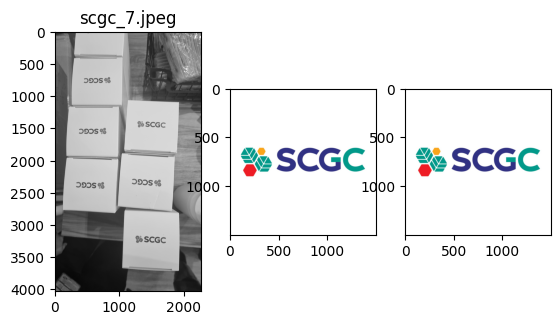

/var/folders/qc/p47pk0895gqf_sgg3vgy46g40000gn/T/ipykernel_53917/2311969795.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['class'] = submission['Predicted']


tensor([[0.0128, 0.0131, 0.0131, 0.0128, 0.0160, 0.0162, 0.0160, 0.0166, 0.0131,
         0.0134, 0.0134, 0.0133, 0.0124, 0.0126, 0.0125, 0.0124, 0.0133, 0.0133,
         0.0137, 0.0131, 0.0115, 0.0115, 0.0117, 0.0117, 0.0134, 0.0138, 0.0138,
         0.0137, 0.0112, 0.0115, 0.0115, 0.0116, 0.0145, 0.0148, 0.0148, 0.0147,
         0.0116, 0.0120, 0.0120, 0.0120, 0.0132, 0.0135, 0.0135, 0.0133, 0.0136,
         0.0141, 0.0141, 0.0139, 0.0126, 0.0127, 0.0129, 0.0129, 0.0130, 0.0133,
         0.0133, 0.0131, 0.0130, 0.0130, 0.0129, 0.0129, 0.0149, 0.0155, 0.0153,
         0.0152, 0.0115, 0.0122, 0.0122, 0.0122, 0.0131, 0.0132, 0.0133, 0.0130,
         0.0119, 0.0118, 0.0117, 0.0119]])
tensor(0.0166)


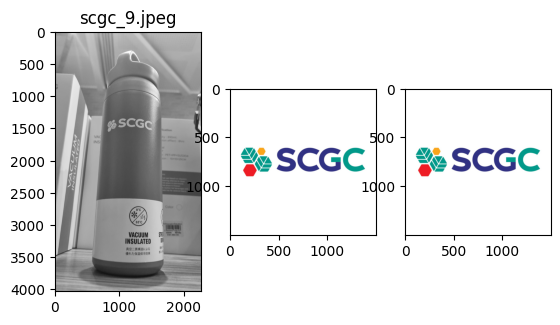

/var/folders/qc/p47pk0895gqf_sgg3vgy46g40000gn/T/ipykernel_53917/2311969795.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['class'] = submission['Predicted']


tensor([[0.0121, 0.0123, 0.0123, 0.0122, 0.0175, 0.0178, 0.0176, 0.0181, 0.0122,
         0.0124, 0.0124, 0.0123, 0.0124, 0.0127, 0.0126, 0.0127, 0.0120, 0.0120,
         0.0122, 0.0118, 0.0128, 0.0127, 0.0127, 0.0128, 0.0131, 0.0131, 0.0131,
         0.0127, 0.0118, 0.0121, 0.0121, 0.0121, 0.0136, 0.0136, 0.0136, 0.0135,
         0.0124, 0.0126, 0.0126, 0.0128, 0.0130, 0.0132, 0.0132, 0.0131, 0.0129,
         0.0132, 0.0132, 0.0132, 0.0120, 0.0120, 0.0122, 0.0123, 0.0128, 0.0129,
         0.0128, 0.0127, 0.0123, 0.0123, 0.0122, 0.0123, 0.0190, 0.0197, 0.0197,
         0.0196, 0.0115, 0.0119, 0.0119, 0.0120, 0.0130, 0.0129, 0.0130, 0.0128,
         0.0113, 0.0115, 0.0113, 0.0113]])
tensor(0.0197)


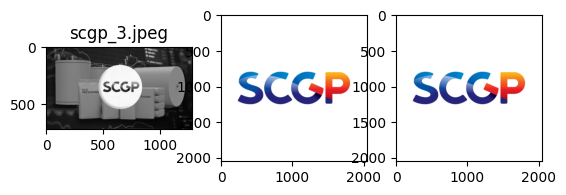

/var/folders/qc/p47pk0895gqf_sgg3vgy46g40000gn/T/ipykernel_53917/2311969795.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['class'] = submission['Predicted']


tensor([[0.0130, 0.0132, 0.0132, 0.0126, 0.0151, 0.0154, 0.0151, 0.0155, 0.0132,
         0.0132, 0.0132, 0.0129, 0.0134, 0.0133, 0.0129, 0.0128, 0.0127, 0.0127,
         0.0124, 0.0124, 0.0117, 0.0117, 0.0118, 0.0118, 0.0134, 0.0131, 0.0131,
         0.0130, 0.0113, 0.0114, 0.0114, 0.0115, 0.0153, 0.0150, 0.0150, 0.0153,
         0.0125, 0.0124, 0.0123, 0.0123, 0.0139, 0.0140, 0.0139, 0.0136, 0.0141,
         0.0144, 0.0144, 0.0142, 0.0121, 0.0121, 0.0124, 0.0124, 0.0129, 0.0130,
         0.0129, 0.0126, 0.0126, 0.0126, 0.0125, 0.0124, 0.0158, 0.0167, 0.0163,
         0.0161, 0.0120, 0.0124, 0.0121, 0.0119, 0.0139, 0.0136, 0.0135, 0.0133,
         0.0117, 0.0115, 0.0113, 0.0113]])
tensor(0.0167)


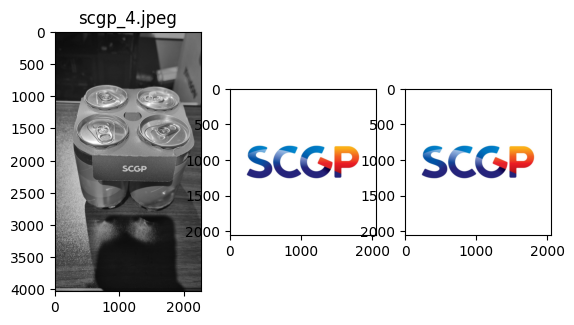

/var/folders/qc/p47pk0895gqf_sgg3vgy46g40000gn/T/ipykernel_53917/2311969795.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['class'] = submission['Predicted']


tensor([[0.0126, 0.0129, 0.0129, 0.0124, 0.0155, 0.0157, 0.0155, 0.0158, 0.0130,
         0.0130, 0.0130, 0.0127, 0.0131, 0.0130, 0.0127, 0.0125, 0.0129, 0.0129,
         0.0126, 0.0126, 0.0117, 0.0117, 0.0119, 0.0118, 0.0135, 0.0134, 0.0134,
         0.0132, 0.0114, 0.0116, 0.0116, 0.0116, 0.0150, 0.0149, 0.0149, 0.0151,
         0.0126, 0.0126, 0.0125, 0.0125, 0.0137, 0.0138, 0.0137, 0.0134, 0.0137,
         0.0139, 0.0139, 0.0138, 0.0120, 0.0121, 0.0123, 0.0123, 0.0129, 0.0131,
         0.0130, 0.0126, 0.0127, 0.0127, 0.0126, 0.0125, 0.0163, 0.0171, 0.0167,
         0.0165, 0.0119, 0.0125, 0.0120, 0.0120, 0.0137, 0.0135, 0.0135, 0.0132,
         0.0118, 0.0117, 0.0114, 0.0114]])
tensor(0.0171)


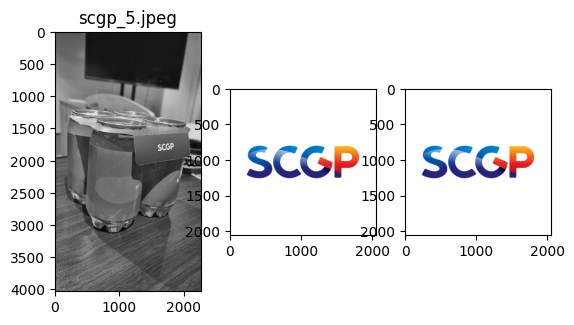

/var/folders/qc/p47pk0895gqf_sgg3vgy46g40000gn/T/ipykernel_53917/2311969795.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['class'] = submission['Predicted']


tensor([[0.0130, 0.0132, 0.0132, 0.0127, 0.0140, 0.0142, 0.0140, 0.0143, 0.0132,
         0.0133, 0.0133, 0.0131, 0.0131, 0.0130, 0.0128, 0.0125, 0.0133, 0.0133,
         0.0130, 0.0130, 0.0114, 0.0115, 0.0117, 0.0116, 0.0136, 0.0137, 0.0137,
         0.0135, 0.0113, 0.0116, 0.0116, 0.0116, 0.0154, 0.0153, 0.0153, 0.0156,
         0.0123, 0.0124, 0.0123, 0.0123, 0.0136, 0.0137, 0.0136, 0.0134, 0.0140,
         0.0143, 0.0143, 0.0141, 0.0122, 0.0123, 0.0125, 0.0125, 0.0134, 0.0136,
         0.0134, 0.0131, 0.0133, 0.0133, 0.0132, 0.0130, 0.0148, 0.0157, 0.0153,
         0.0150, 0.0117, 0.0123, 0.0119, 0.0118, 0.0140, 0.0138, 0.0137, 0.0135,
         0.0119, 0.0118, 0.0115, 0.0115]])
tensor(0.0157)


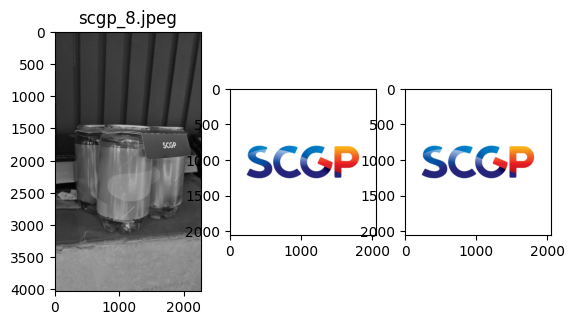

/var/folders/qc/p47pk0895gqf_sgg3vgy46g40000gn/T/ipykernel_53917/2311969795.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['class'] = submission['Predicted']


tensor([[0.0138, 0.0142, 0.0142, 0.0133, 0.0115, 0.0118, 0.0116, 0.0117, 0.0141,
         0.0142, 0.0142, 0.0138, 0.0137, 0.0136, 0.0131, 0.0127, 0.0136, 0.0136,
         0.0134, 0.0133, 0.0113, 0.0115, 0.0117, 0.0116, 0.0143, 0.0143, 0.0143,
         0.0141, 0.0111, 0.0114, 0.0114, 0.0114, 0.0145, 0.0148, 0.0148, 0.0153,
         0.0126, 0.0125, 0.0124, 0.0124, 0.0141, 0.0142, 0.0141, 0.0135, 0.0141,
         0.0144, 0.0144, 0.0142, 0.0125, 0.0125, 0.0128, 0.0129, 0.0138, 0.0139,
         0.0138, 0.0132, 0.0142, 0.0142, 0.0140, 0.0138, 0.0119, 0.0124, 0.0120,
         0.0117, 0.0119, 0.0126, 0.0120, 0.0116, 0.0143, 0.0140, 0.0139, 0.0136,
         0.0129, 0.0128, 0.0123, 0.0123]])
tensor(0.0153)


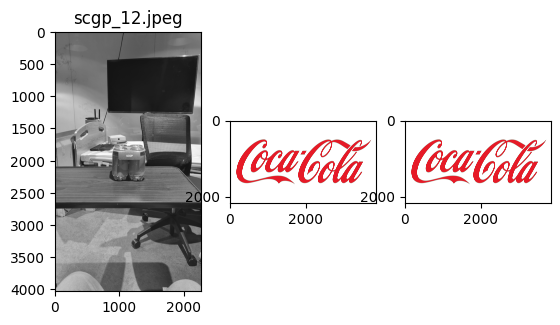

/var/folders/qc/p47pk0895gqf_sgg3vgy46g40000gn/T/ipykernel_53917/2311969795.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['class'] = submission['Predicted']


tensor([[0.0123, 0.0125, 0.0125, 0.0123, 0.0178, 0.0183, 0.0180, 0.0186, 0.0124,
         0.0127, 0.0127, 0.0126, 0.0120, 0.0124, 0.0122, 0.0122, 0.0132, 0.0132,
         0.0131, 0.0129, 0.0125, 0.0125, 0.0128, 0.0127, 0.0131, 0.0135, 0.0135,
         0.0134, 0.0115, 0.0117, 0.0117, 0.0119, 0.0131, 0.0133, 0.0133, 0.0134,
         0.0118, 0.0123, 0.0123, 0.0124, 0.0126, 0.0129, 0.0130, 0.0127, 0.0121,
         0.0125, 0.0125, 0.0124, 0.0120, 0.0120, 0.0123, 0.0123, 0.0127, 0.0130,
         0.0129, 0.0126, 0.0121, 0.0121, 0.0120, 0.0120, 0.0198, 0.0212, 0.0210,
         0.0210, 0.0109, 0.0116, 0.0115, 0.0116, 0.0125, 0.0126, 0.0126, 0.0125,
         0.0116, 0.0115, 0.0113, 0.0115]])
tensor(0.0212)


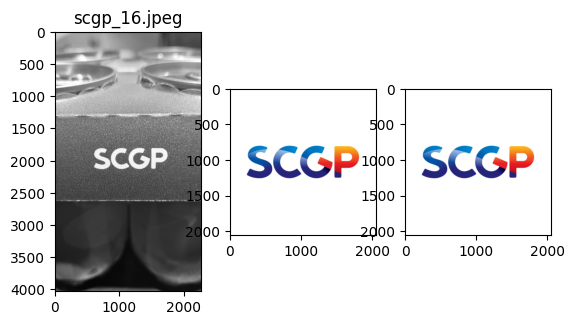

/var/folders/qc/p47pk0895gqf_sgg3vgy46g40000gn/T/ipykernel_53917/2311969795.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['class'] = submission['Predicted']


tensor([[0.0130, 0.0132, 0.0132, 0.0127, 0.0110, 0.0114, 0.0112, 0.0114, 0.0137,
         0.0141, 0.0141, 0.0137, 0.0121, 0.0122, 0.0119, 0.0115, 0.0133, 0.0133,
         0.0133, 0.0130, 0.0108, 0.0108, 0.0109, 0.0112, 0.0137, 0.0135, 0.0135,
         0.0133, 0.0114, 0.0117, 0.0117, 0.0118, 0.0136, 0.0137, 0.0137, 0.0138,
         0.0117, 0.0120, 0.0119, 0.0120, 0.0129, 0.0131, 0.0131, 0.0126, 0.0125,
         0.0129, 0.0129, 0.0126, 0.0136, 0.0136, 0.0139, 0.0139, 0.0152, 0.0154,
         0.0152, 0.0143, 0.0144, 0.0144, 0.0143, 0.0141, 0.0113, 0.0117, 0.0114,
         0.0112, 0.0121, 0.0128, 0.0125, 0.0126, 0.0134, 0.0132, 0.0132, 0.0130,
         0.0193, 0.0192, 0.0189, 0.0191]])
tensor(0.0193)


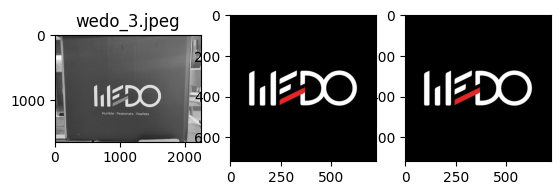

/var/folders/qc/p47pk0895gqf_sgg3vgy46g40000gn/T/ipykernel_53917/2311969795.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['class'] = submission['Predicted']


tensor([[0.0132, 0.0135, 0.0135, 0.0130, 0.0113, 0.0116, 0.0115, 0.0118, 0.0137,
         0.0141, 0.0141, 0.0137, 0.0124, 0.0124, 0.0121, 0.0119, 0.0134, 0.0134,
         0.0134, 0.0130, 0.0112, 0.0112, 0.0113, 0.0115, 0.0139, 0.0141, 0.0141,
         0.0137, 0.0122, 0.0124, 0.0124, 0.0124, 0.0135, 0.0138, 0.0138, 0.0138,
         0.0117, 0.0118, 0.0118, 0.0118, 0.0131, 0.0133, 0.0132, 0.0128, 0.0129,
         0.0132, 0.0132, 0.0129, 0.0133, 0.0133, 0.0136, 0.0136, 0.0148, 0.0151,
         0.0149, 0.0142, 0.0143, 0.0143, 0.0141, 0.0139, 0.0114, 0.0119, 0.0116,
         0.0115, 0.0120, 0.0125, 0.0123, 0.0124, 0.0136, 0.0134, 0.0134, 0.0131,
         0.0171, 0.0171, 0.0169, 0.0172]])
tensor(0.0172)


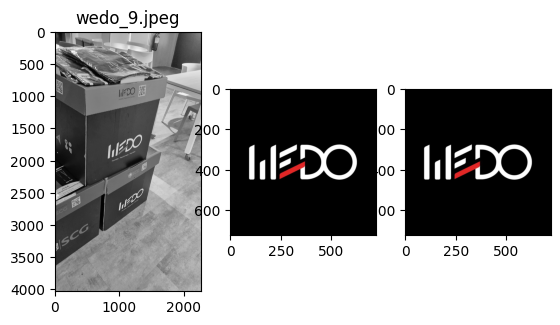

/var/folders/qc/p47pk0895gqf_sgg3vgy46g40000gn/T/ipykernel_53917/2311969795.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['class'] = submission['Predicted']


tensor([[0.0130, 0.0133, 0.0133, 0.0128, 0.0121, 0.0124, 0.0122, 0.0125, 0.0138,
         0.0141, 0.0141, 0.0138, 0.0125, 0.0126, 0.0123, 0.0120, 0.0132, 0.0132,
         0.0131, 0.0128, 0.0111, 0.0111, 0.0113, 0.0114, 0.0136, 0.0136, 0.0136,
         0.0132, 0.0120, 0.0123, 0.0123, 0.0122, 0.0140, 0.0140, 0.0140, 0.0140,
         0.0120, 0.0122, 0.0121, 0.0120, 0.0133, 0.0134, 0.0134, 0.0130, 0.0130,
         0.0133, 0.0133, 0.0130, 0.0129, 0.0129, 0.0132, 0.0133, 0.0145, 0.0147,
         0.0145, 0.0138, 0.0141, 0.0141, 0.0139, 0.0138, 0.0121, 0.0126, 0.0123,
         0.0122, 0.0122, 0.0127, 0.0124, 0.0124, 0.0136, 0.0134, 0.0134, 0.0131,
         0.0163, 0.0163, 0.0161, 0.0163]])
tensor(0.0163)


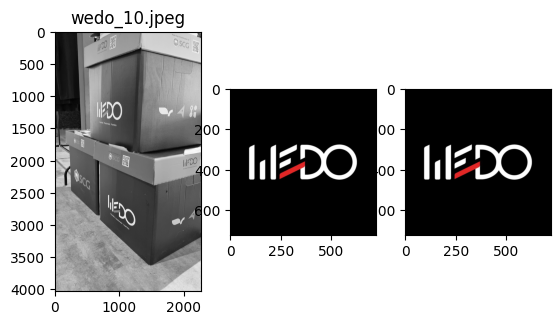

/var/folders/qc/p47pk0895gqf_sgg3vgy46g40000gn/T/ipykernel_53917/2311969795.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['class'] = submission['Predicted']


tensor([[0.0135, 0.0139, 0.0139, 0.0131, 0.0112, 0.0113, 0.0111, 0.0114, 0.0140,
         0.0141, 0.0141, 0.0137, 0.0135, 0.0135, 0.0130, 0.0127, 0.0136, 0.0136,
         0.0133, 0.0133, 0.0110, 0.0109, 0.0113, 0.0111, 0.0138, 0.0134, 0.0134,
         0.0133, 0.0111, 0.0113, 0.0113, 0.0115, 0.0157, 0.0156, 0.0156, 0.0160,
         0.0131, 0.0127, 0.0126, 0.0126, 0.0142, 0.0142, 0.0141, 0.0137, 0.0149,
         0.0152, 0.0152, 0.0148, 0.0124, 0.0124, 0.0127, 0.0128, 0.0142, 0.0143,
         0.0141, 0.0135, 0.0143, 0.0143, 0.0141, 0.0138, 0.0112, 0.0117, 0.0113,
         0.0112, 0.0127, 0.0132, 0.0126, 0.0123, 0.0143, 0.0138, 0.0139, 0.0135,
         0.0128, 0.0126, 0.0122, 0.0124]])
tensor(0.0160)


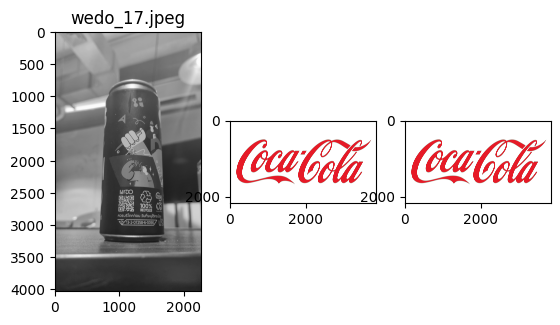

/var/folders/qc/p47pk0895gqf_sgg3vgy46g40000gn/T/ipykernel_53917/2311969795.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['class'] = submission['Predicted']


tensor([[0.0129, 0.0132, 0.0132, 0.0124, 0.0115, 0.0115, 0.0113, 0.0115, 0.0136,
         0.0136, 0.0136, 0.0131, 0.0139, 0.0136, 0.0131, 0.0127, 0.0126, 0.0126,
         0.0124, 0.0123, 0.0114, 0.0114, 0.0116, 0.0116, 0.0138, 0.0132, 0.0132,
         0.0131, 0.0115, 0.0116, 0.0116, 0.0117, 0.0152, 0.0149, 0.0149, 0.0151,
         0.0127, 0.0125, 0.0124, 0.0123, 0.0141, 0.0141, 0.0140, 0.0135, 0.0151,
         0.0154, 0.0154, 0.0150, 0.0120, 0.0120, 0.0123, 0.0123, 0.0132, 0.0134,
         0.0132, 0.0128, 0.0142, 0.0142, 0.0140, 0.0139, 0.0113, 0.0116, 0.0112,
         0.0110, 0.0166, 0.0170, 0.0164, 0.0160, 0.0146, 0.0140, 0.0141, 0.0137,
         0.0123, 0.0120, 0.0117, 0.0119]])
tensor(0.0170)


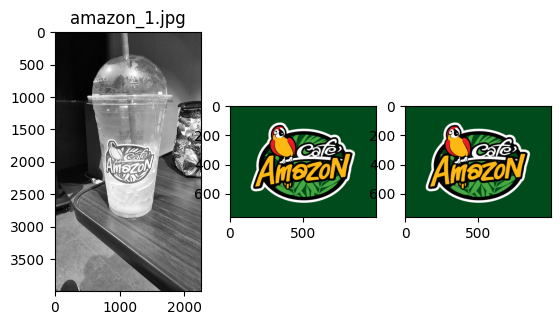

/var/folders/qc/p47pk0895gqf_sgg3vgy46g40000gn/T/ipykernel_53917/2311969795.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['class'] = submission['Predicted']


tensor([[0.0127, 0.0130, 0.0130, 0.0122, 0.0116, 0.0115, 0.0113, 0.0115, 0.0135,
         0.0135, 0.0135, 0.0130, 0.0141, 0.0136, 0.0131, 0.0128, 0.0126, 0.0126,
         0.0123, 0.0124, 0.0115, 0.0115, 0.0116, 0.0116, 0.0133, 0.0127, 0.0127,
         0.0126, 0.0116, 0.0116, 0.0116, 0.0117, 0.0154, 0.0150, 0.0149, 0.0152,
         0.0126, 0.0124, 0.0123, 0.0123, 0.0143, 0.0143, 0.0141, 0.0137, 0.0152,
         0.0156, 0.0156, 0.0152, 0.0121, 0.0121, 0.0123, 0.0124, 0.0133, 0.0133,
         0.0132, 0.0128, 0.0140, 0.0140, 0.0138, 0.0136, 0.0113, 0.0115, 0.0111,
         0.0109, 0.0170, 0.0172, 0.0166, 0.0163, 0.0147, 0.0141, 0.0141, 0.0138,
         0.0125, 0.0122, 0.0119, 0.0121]])
tensor(0.0172)


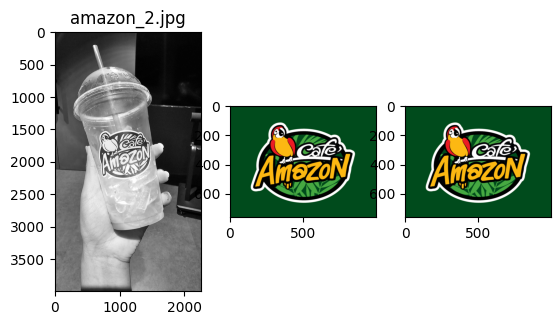

/var/folders/qc/p47pk0895gqf_sgg3vgy46g40000gn/T/ipykernel_53917/2311969795.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['class'] = submission['Predicted']


tensor([[0.0131, 0.0133, 0.0133, 0.0124, 0.0115, 0.0115, 0.0113, 0.0115, 0.0137,
         0.0137, 0.0137, 0.0132, 0.0137, 0.0134, 0.0129, 0.0125, 0.0127, 0.0127,
         0.0125, 0.0125, 0.0116, 0.0116, 0.0118, 0.0118, 0.0135, 0.0128, 0.0128,
         0.0126, 0.0117, 0.0118, 0.0118, 0.0119, 0.0152, 0.0148, 0.0148, 0.0149,
         0.0128, 0.0127, 0.0126, 0.0125, 0.0140, 0.0140, 0.0138, 0.0133, 0.0148,
         0.0151, 0.0151, 0.0147, 0.0121, 0.0121, 0.0124, 0.0124, 0.0134, 0.0135,
         0.0133, 0.0128, 0.0141, 0.0141, 0.0139, 0.0137, 0.0114, 0.0115, 0.0112,
         0.0110, 0.0169, 0.0173, 0.0165, 0.0162, 0.0144, 0.0138, 0.0138, 0.0135,
         0.0125, 0.0122, 0.0119, 0.0120]])
tensor(0.0173)


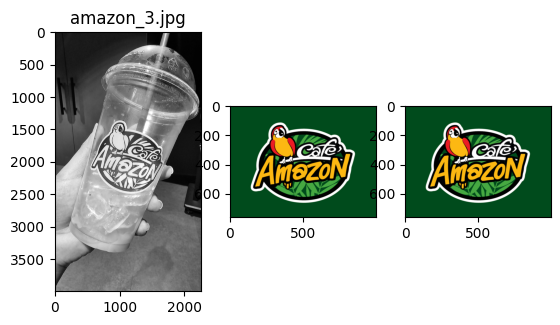

/var/folders/qc/p47pk0895gqf_sgg3vgy46g40000gn/T/ipykernel_53917/2311969795.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['class'] = submission['Predicted']


tensor([[0.0130, 0.0132, 0.0132, 0.0124, 0.0117, 0.0116, 0.0114, 0.0116, 0.0136,
         0.0136, 0.0136, 0.0131, 0.0139, 0.0135, 0.0130, 0.0126, 0.0124, 0.0124,
         0.0123, 0.0122, 0.0113, 0.0113, 0.0115, 0.0115, 0.0136, 0.0130, 0.0130,
         0.0128, 0.0114, 0.0115, 0.0115, 0.0116, 0.0154, 0.0149, 0.0149, 0.0151,
         0.0127, 0.0125, 0.0124, 0.0124, 0.0142, 0.0142, 0.0140, 0.0135, 0.0150,
         0.0154, 0.0154, 0.0150, 0.0120, 0.0120, 0.0122, 0.0122, 0.0131, 0.0132,
         0.0130, 0.0126, 0.0140, 0.0140, 0.0138, 0.0136, 0.0115, 0.0116, 0.0112,
         0.0110, 0.0176, 0.0179, 0.0173, 0.0169, 0.0146, 0.0140, 0.0140, 0.0138,
         0.0123, 0.0120, 0.0117, 0.0119]])
tensor(0.0179)


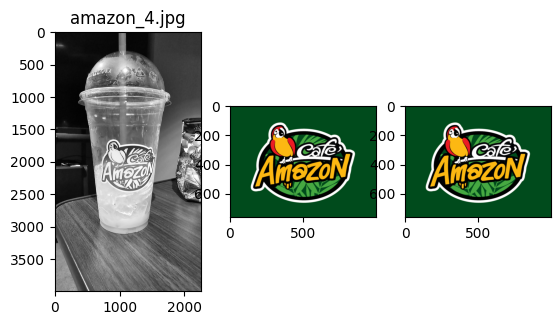

/var/folders/qc/p47pk0895gqf_sgg3vgy46g40000gn/T/ipykernel_53917/2311969795.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['class'] = submission['Predicted']


tensor([[0.0129, 0.0132, 0.0132, 0.0125, 0.0113, 0.0113, 0.0111, 0.0113, 0.0138,
         0.0138, 0.0138, 0.0133, 0.0146, 0.0142, 0.0136, 0.0132, 0.0128, 0.0128,
         0.0125, 0.0125, 0.0114, 0.0115, 0.0117, 0.0117, 0.0133, 0.0129, 0.0129,
         0.0128, 0.0113, 0.0114, 0.0114, 0.0115, 0.0153, 0.0151, 0.0151, 0.0154,
         0.0132, 0.0129, 0.0128, 0.0127, 0.0145, 0.0145, 0.0143, 0.0138, 0.0152,
         0.0155, 0.0155, 0.0151, 0.0121, 0.0121, 0.0123, 0.0124, 0.0136, 0.0137,
         0.0135, 0.0132, 0.0142, 0.0142, 0.0140, 0.0138, 0.0112, 0.0115, 0.0111,
         0.0110, 0.0147, 0.0149, 0.0144, 0.0141, 0.0150, 0.0145, 0.0145, 0.0141,
         0.0121, 0.0119, 0.0116, 0.0117]])
tensor(0.0155)


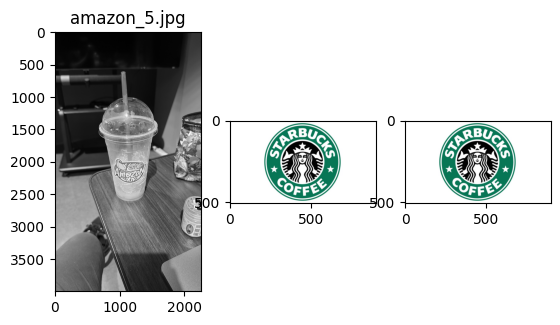

/var/folders/qc/p47pk0895gqf_sgg3vgy46g40000gn/T/ipykernel_53917/2311969795.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['class'] = submission['Predicted']


tensor([[0.0129, 0.0131, 0.0131, 0.0126, 0.0117, 0.0119, 0.0117, 0.0119, 0.0131,
         0.0132, 0.0132, 0.0129, 0.0137, 0.0134, 0.0130, 0.0129, 0.0128, 0.0128,
         0.0126, 0.0126, 0.0115, 0.0115, 0.0116, 0.0116, 0.0135, 0.0130, 0.0130,
         0.0129, 0.0114, 0.0116, 0.0116, 0.0117, 0.0141, 0.0139, 0.0139, 0.0140,
         0.0122, 0.0122, 0.0121, 0.0122, 0.0141, 0.0142, 0.0141, 0.0137, 0.0147,
         0.0149, 0.0149, 0.0148, 0.0122, 0.0123, 0.0124, 0.0125, 0.0133, 0.0134,
         0.0132, 0.0129, 0.0137, 0.0137, 0.0136, 0.0135, 0.0116, 0.0121, 0.0117,
         0.0116, 0.0178, 0.0181, 0.0179, 0.0176, 0.0145, 0.0140, 0.0140, 0.0138,
         0.0123, 0.0122, 0.0119, 0.0121]])
tensor(0.0181)


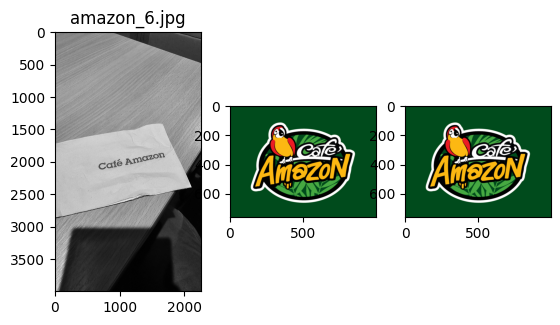

/var/folders/qc/p47pk0895gqf_sgg3vgy46g40000gn/T/ipykernel_53917/2311969795.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['class'] = submission['Predicted']


tensor([[0.0129, 0.0132, 0.0132, 0.0127, 0.0115, 0.0118, 0.0116, 0.0118, 0.0130,
         0.0132, 0.0132, 0.0128, 0.0134, 0.0132, 0.0129, 0.0127, 0.0131, 0.0131,
         0.0128, 0.0129, 0.0119, 0.0119, 0.0121, 0.0121, 0.0136, 0.0132, 0.0132,
         0.0131, 0.0113, 0.0114, 0.0114, 0.0115, 0.0141, 0.0140, 0.0140, 0.0143,
         0.0119, 0.0120, 0.0119, 0.0120, 0.0137, 0.0139, 0.0138, 0.0134, 0.0144,
         0.0147, 0.0147, 0.0146, 0.0121, 0.0121, 0.0124, 0.0125, 0.0134, 0.0136,
         0.0134, 0.0130, 0.0138, 0.0138, 0.0136, 0.0135, 0.0116, 0.0121, 0.0117,
         0.0116, 0.0180, 0.0184, 0.0183, 0.0180, 0.0142, 0.0138, 0.0138, 0.0136,
         0.0124, 0.0123, 0.0121, 0.0124]])
tensor(0.0184)


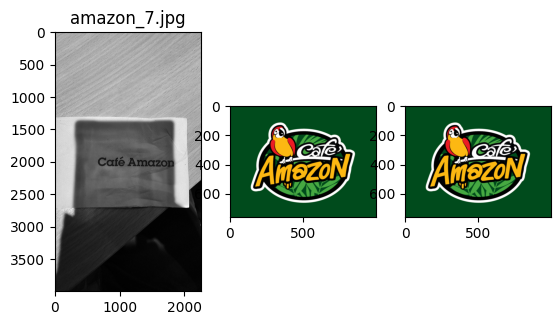

/var/folders/qc/p47pk0895gqf_sgg3vgy46g40000gn/T/ipykernel_53917/2311969795.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['class'] = submission['Predicted']


tensor([[0.0130, 0.0132, 0.0132, 0.0126, 0.0116, 0.0117, 0.0115, 0.0118, 0.0133,
         0.0133, 0.0133, 0.0129, 0.0138, 0.0134, 0.0130, 0.0129, 0.0127, 0.0127,
         0.0125, 0.0126, 0.0116, 0.0116, 0.0117, 0.0118, 0.0136, 0.0130, 0.0130,
         0.0128, 0.0114, 0.0116, 0.0116, 0.0117, 0.0142, 0.0139, 0.0139, 0.0140,
         0.0123, 0.0123, 0.0122, 0.0122, 0.0141, 0.0142, 0.0141, 0.0137, 0.0146,
         0.0148, 0.0148, 0.0147, 0.0122, 0.0123, 0.0124, 0.0126, 0.0132, 0.0133,
         0.0132, 0.0128, 0.0138, 0.0138, 0.0136, 0.0135, 0.0116, 0.0120, 0.0116,
         0.0115, 0.0179, 0.0182, 0.0179, 0.0174, 0.0145, 0.0139, 0.0139, 0.0137,
         0.0124, 0.0121, 0.0119, 0.0121]])
tensor(0.0182)


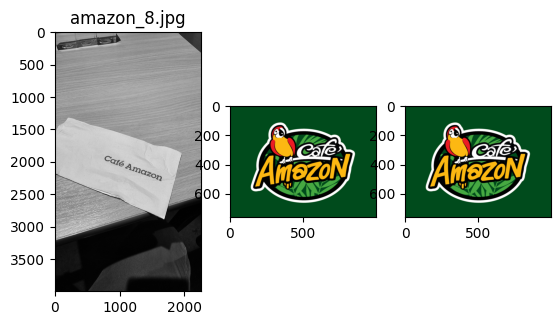

/var/folders/qc/p47pk0895gqf_sgg3vgy46g40000gn/T/ipykernel_53917/2311969795.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['class'] = submission['Predicted']


tensor([[0.0130, 0.0132, 0.0132, 0.0126, 0.0116, 0.0117, 0.0115, 0.0117, 0.0133,
         0.0133, 0.0134, 0.0130, 0.0139, 0.0136, 0.0131, 0.0130, 0.0126, 0.0126,
         0.0125, 0.0124, 0.0116, 0.0116, 0.0117, 0.0118, 0.0136, 0.0130, 0.0130,
         0.0128, 0.0114, 0.0115, 0.0115, 0.0116, 0.0141, 0.0138, 0.0138, 0.0139,
         0.0123, 0.0122, 0.0121, 0.0121, 0.0142, 0.0143, 0.0142, 0.0137, 0.0145,
         0.0148, 0.0148, 0.0146, 0.0122, 0.0123, 0.0125, 0.0126, 0.0134, 0.0135,
         0.0133, 0.0130, 0.0138, 0.0138, 0.0136, 0.0136, 0.0115, 0.0118, 0.0115,
         0.0114, 0.0178, 0.0180, 0.0178, 0.0172, 0.0148, 0.0142, 0.0142, 0.0140,
         0.0124, 0.0122, 0.0119, 0.0120]])
tensor(0.0180)


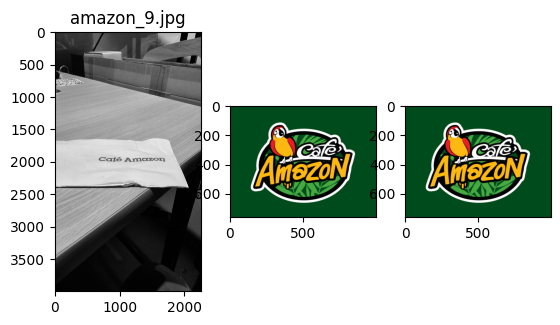

/var/folders/qc/p47pk0895gqf_sgg3vgy46g40000gn/T/ipykernel_53917/2311969795.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['class'] = submission['Predicted']


tensor([[0.0142, 0.0144, 0.0144, 0.0135, 0.0110, 0.0111, 0.0109, 0.0114, 0.0151,
         0.0151, 0.0151, 0.0147, 0.0137, 0.0132, 0.0128, 0.0125, 0.0131, 0.0131,
         0.0129, 0.0128, 0.0108, 0.0108, 0.0111, 0.0110, 0.0189, 0.0174, 0.0174,
         0.0168, 0.0112, 0.0113, 0.0113, 0.0115, 0.0140, 0.0142, 0.0142, 0.0144,
         0.0119, 0.0119, 0.0118, 0.0119, 0.0142, 0.0143, 0.0142, 0.0136, 0.0136,
         0.0139, 0.0139, 0.0136, 0.0128, 0.0128, 0.0131, 0.0131, 0.0141, 0.0142,
         0.0140, 0.0135, 0.0149, 0.0149, 0.0147, 0.0146, 0.0111, 0.0115, 0.0112,
         0.0111, 0.0112, 0.0116, 0.0111, 0.0108, 0.0145, 0.0140, 0.0139, 0.0137,
         0.0122, 0.0120, 0.0117, 0.0118]])
tensor(0.0189)


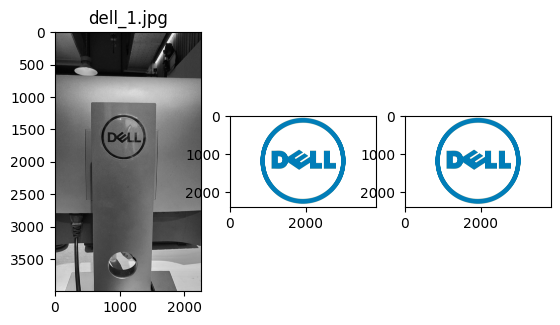

/var/folders/qc/p47pk0895gqf_sgg3vgy46g40000gn/T/ipykernel_53917/2311969795.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['class'] = submission['Predicted']


tensor([[0.0143, 0.0146, 0.0146, 0.0138, 0.0110, 0.0111, 0.0109, 0.0114, 0.0150,
         0.0151, 0.0151, 0.0147, 0.0134, 0.0130, 0.0127, 0.0125, 0.0130, 0.0130,
         0.0129, 0.0127, 0.0107, 0.0108, 0.0110, 0.0110, 0.0190, 0.0176, 0.0176,
         0.0170, 0.0111, 0.0113, 0.0113, 0.0115, 0.0140, 0.0143, 0.0143, 0.0145,
         0.0116, 0.0117, 0.0116, 0.0118, 0.0139, 0.0141, 0.0140, 0.0135, 0.0138,
         0.0140, 0.0140, 0.0138, 0.0129, 0.0129, 0.0132, 0.0132, 0.0141, 0.0144,
         0.0142, 0.0137, 0.0149, 0.0149, 0.0147, 0.0147, 0.0110, 0.0115, 0.0112,
         0.0110, 0.0110, 0.0116, 0.0112, 0.0110, 0.0143, 0.0139, 0.0139, 0.0137,
         0.0121, 0.0119, 0.0116, 0.0118]])
tensor(0.0190)


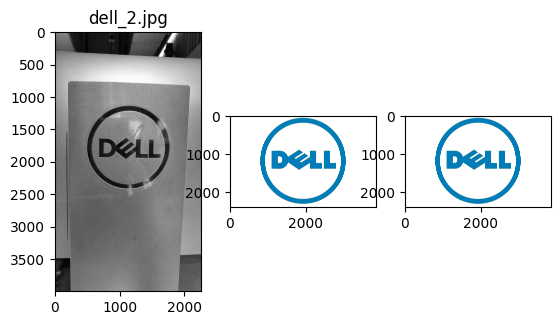

/var/folders/qc/p47pk0895gqf_sgg3vgy46g40000gn/T/ipykernel_53917/2311969795.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['class'] = submission['Predicted']


tensor([[0.0141, 0.0144, 0.0144, 0.0137, 0.0110, 0.0112, 0.0110, 0.0114, 0.0149,
         0.0151, 0.0151, 0.0149, 0.0134, 0.0131, 0.0127, 0.0125, 0.0136, 0.0136,
         0.0133, 0.0133, 0.0109, 0.0110, 0.0113, 0.0113, 0.0185, 0.0176, 0.0177,
         0.0173, 0.0112, 0.0114, 0.0114, 0.0116, 0.0138, 0.0143, 0.0143, 0.0147,
         0.0116, 0.0118, 0.0117, 0.0119, 0.0136, 0.0138, 0.0138, 0.0134, 0.0133,
         0.0136, 0.0136, 0.0134, 0.0128, 0.0128, 0.0132, 0.0132, 0.0139, 0.0142,
         0.0141, 0.0136, 0.0150, 0.0150, 0.0148, 0.0147, 0.0111, 0.0116, 0.0113,
         0.0113, 0.0109, 0.0115, 0.0111, 0.0108, 0.0141, 0.0138, 0.0138, 0.0136,
         0.0121, 0.0119, 0.0116, 0.0117]])
tensor(0.0185)


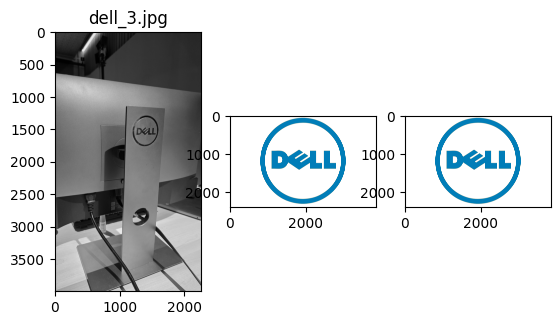

/var/folders/qc/p47pk0895gqf_sgg3vgy46g40000gn/T/ipykernel_53917/2311969795.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['class'] = submission['Predicted']


tensor([[0.0140, 0.0143, 0.0143, 0.0136, 0.0109, 0.0111, 0.0109, 0.0114, 0.0148,
         0.0149, 0.0149, 0.0147, 0.0134, 0.0131, 0.0128, 0.0125, 0.0137, 0.0137,
         0.0133, 0.0134, 0.0107, 0.0109, 0.0112, 0.0111, 0.0187, 0.0177, 0.0177,
         0.0174, 0.0111, 0.0113, 0.0113, 0.0115, 0.0139, 0.0144, 0.0143, 0.0147,
         0.0116, 0.0118, 0.0118, 0.0119, 0.0138, 0.0140, 0.0139, 0.0136, 0.0134,
         0.0136, 0.0136, 0.0135, 0.0126, 0.0127, 0.0130, 0.0131, 0.0140, 0.0143,
         0.0142, 0.0137, 0.0150, 0.0150, 0.0148, 0.0147, 0.0111, 0.0117, 0.0113,
         0.0112, 0.0110, 0.0116, 0.0112, 0.0109, 0.0142, 0.0139, 0.0139, 0.0137,
         0.0120, 0.0119, 0.0116, 0.0117]])
tensor(0.0187)


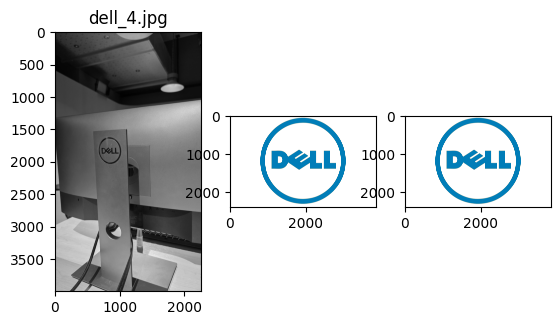

/var/folders/qc/p47pk0895gqf_sgg3vgy46g40000gn/T/ipykernel_53917/2311969795.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['class'] = submission['Predicted']


tensor([[0.0141, 0.0144, 0.0144, 0.0138, 0.0109, 0.0111, 0.0109, 0.0114, 0.0147,
         0.0149, 0.0149, 0.0147, 0.0133, 0.0131, 0.0128, 0.0126, 0.0136, 0.0136,
         0.0133, 0.0133, 0.0107, 0.0109, 0.0112, 0.0111, 0.0186, 0.0177, 0.0177,
         0.0174, 0.0111, 0.0113, 0.0113, 0.0115, 0.0138, 0.0143, 0.0143, 0.0147,
         0.0116, 0.0118, 0.0118, 0.0119, 0.0136, 0.0138, 0.0138, 0.0134, 0.0135,
         0.0137, 0.0137, 0.0135, 0.0127, 0.0127, 0.0131, 0.0131, 0.0140, 0.0143,
         0.0142, 0.0136, 0.0150, 0.0150, 0.0148, 0.0147, 0.0110, 0.0116, 0.0113,
         0.0112, 0.0109, 0.0116, 0.0112, 0.0109, 0.0141, 0.0139, 0.0139, 0.0137,
         0.0122, 0.0121, 0.0118, 0.0120]])
tensor(0.0186)


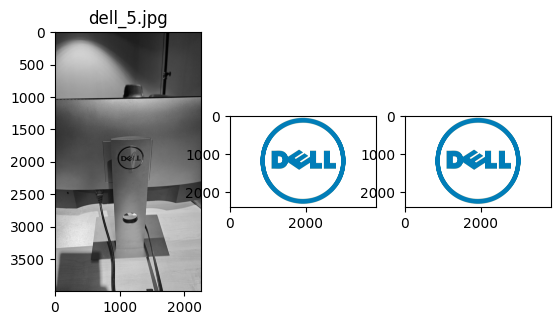

/var/folders/qc/p47pk0895gqf_sgg3vgy46g40000gn/T/ipykernel_53917/2311969795.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['class'] = submission['Predicted']


tensor([[0.0142, 0.0144, 0.0144, 0.0137, 0.0110, 0.0111, 0.0109, 0.0114, 0.0149,
         0.0150, 0.0150, 0.0147, 0.0134, 0.0132, 0.0128, 0.0125, 0.0136, 0.0136,
         0.0133, 0.0134, 0.0109, 0.0110, 0.0112, 0.0112, 0.0187, 0.0176, 0.0176,
         0.0173, 0.0111, 0.0114, 0.0114, 0.0116, 0.0138, 0.0142, 0.0142, 0.0146,
         0.0118, 0.0119, 0.0118, 0.0120, 0.0138, 0.0139, 0.0139, 0.0134, 0.0133,
         0.0136, 0.0136, 0.0133, 0.0127, 0.0127, 0.0130, 0.0131, 0.0140, 0.0142,
         0.0141, 0.0136, 0.0150, 0.0150, 0.0148, 0.0146, 0.0111, 0.0117, 0.0113,
         0.0112, 0.0111, 0.0116, 0.0112, 0.0109, 0.0141, 0.0138, 0.0137, 0.0136,
         0.0122, 0.0121, 0.0117, 0.0118]])
tensor(0.0187)


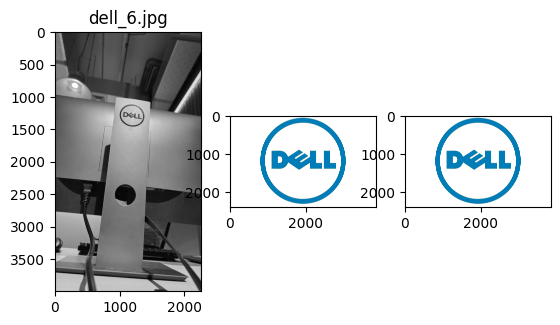

/var/folders/qc/p47pk0895gqf_sgg3vgy46g40000gn/T/ipykernel_53917/2311969795.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['class'] = submission['Predicted']


tensor([[0.0127, 0.0129, 0.0129, 0.0123, 0.0114, 0.0114, 0.0112, 0.0115, 0.0138,
         0.0137, 0.0138, 0.0133, 0.0152, 0.0145, 0.0140, 0.0138, 0.0123, 0.0123,
         0.0121, 0.0122, 0.0118, 0.0117, 0.0120, 0.0118, 0.0138, 0.0131, 0.0131,
         0.0130, 0.0115, 0.0116, 0.0116, 0.0117, 0.0141, 0.0137, 0.0137, 0.0140,
         0.0198, 0.0191, 0.0189, 0.0189, 0.0148, 0.0148, 0.0147, 0.0141, 0.0142,
         0.0145, 0.0145, 0.0142, 0.0119, 0.0119, 0.0121, 0.0121, 0.0128, 0.0129,
         0.0127, 0.0125, 0.0131, 0.0131, 0.0129, 0.0127, 0.0120, 0.0124, 0.0120,
         0.0119, 0.0125, 0.0125, 0.0121, 0.0119, 0.0145, 0.0138, 0.0139, 0.0136,
         0.0112, 0.0111, 0.0108, 0.0111]])
tensor(0.0198)


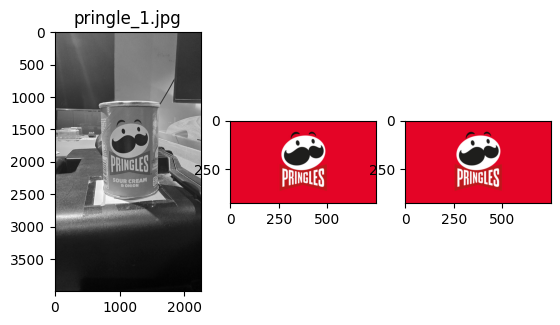

/var/folders/qc/p47pk0895gqf_sgg3vgy46g40000gn/T/ipykernel_53917/2311969795.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['class'] = submission['Predicted']


tensor([[0.0131, 0.0133, 0.0133, 0.0127, 0.0118, 0.0118, 0.0116, 0.0118, 0.0137,
         0.0138, 0.0138, 0.0134, 0.0146, 0.0142, 0.0137, 0.0134, 0.0128, 0.0128,
         0.0127, 0.0127, 0.0117, 0.0118, 0.0120, 0.0118, 0.0139, 0.0135, 0.0135,
         0.0134, 0.0112, 0.0114, 0.0114, 0.0114, 0.0141, 0.0140, 0.0140, 0.0144,
         0.0181, 0.0177, 0.0175, 0.0176, 0.0144, 0.0144, 0.0143, 0.0138, 0.0139,
         0.0142, 0.0142, 0.0140, 0.0119, 0.0119, 0.0122, 0.0122, 0.0128, 0.0128,
         0.0127, 0.0125, 0.0130, 0.0130, 0.0129, 0.0127, 0.0121, 0.0125, 0.0121,
         0.0120, 0.0129, 0.0132, 0.0126, 0.0125, 0.0142, 0.0137, 0.0137, 0.0135,
         0.0115, 0.0114, 0.0112, 0.0115]])
tensor(0.0181)


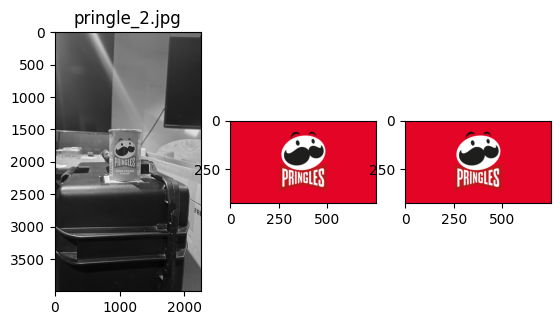

/var/folders/qc/p47pk0895gqf_sgg3vgy46g40000gn/T/ipykernel_53917/2311969795.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['class'] = submission['Predicted']


tensor([[0.0128, 0.0130, 0.0130, 0.0123, 0.0111, 0.0110, 0.0108, 0.0111, 0.0140,
         0.0140, 0.0140, 0.0134, 0.0153, 0.0145, 0.0140, 0.0137, 0.0121, 0.0121,
         0.0119, 0.0120, 0.0115, 0.0114, 0.0117, 0.0116, 0.0137, 0.0129, 0.0129,
         0.0127, 0.0117, 0.0118, 0.0118, 0.0118, 0.0143, 0.0137, 0.0137, 0.0140,
         0.0199, 0.0189, 0.0188, 0.0186, 0.0151, 0.0151, 0.0150, 0.0144, 0.0145,
         0.0148, 0.0148, 0.0144, 0.0118, 0.0118, 0.0120, 0.0120, 0.0131, 0.0131,
         0.0129, 0.0127, 0.0133, 0.0133, 0.0131, 0.0129, 0.0117, 0.0120, 0.0117,
         0.0116, 0.0125, 0.0125, 0.0120, 0.0119, 0.0147, 0.0140, 0.0140, 0.0137,
         0.0112, 0.0111, 0.0108, 0.0110]])
tensor(0.0199)


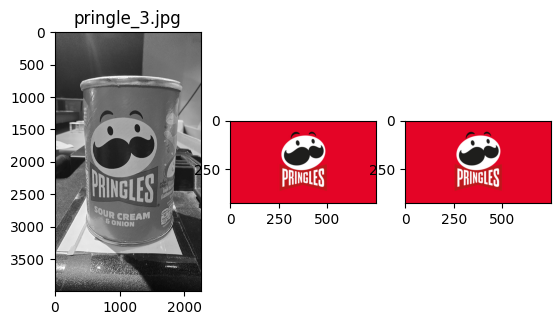

/var/folders/qc/p47pk0895gqf_sgg3vgy46g40000gn/T/ipykernel_53917/2311969795.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['class'] = submission['Predicted']


tensor([[0.0133, 0.0136, 0.0136, 0.0127, 0.0115, 0.0114, 0.0112, 0.0115, 0.0141,
         0.0140, 0.0140, 0.0135, 0.0150, 0.0144, 0.0137, 0.0134, 0.0123, 0.0123,
         0.0120, 0.0122, 0.0118, 0.0117, 0.0119, 0.0119, 0.0138, 0.0131, 0.0131,
         0.0131, 0.0114, 0.0115, 0.0115, 0.0115, 0.0141, 0.0136, 0.0136, 0.0141,
         0.0184, 0.0177, 0.0176, 0.0175, 0.0148, 0.0148, 0.0146, 0.0139, 0.0146,
         0.0149, 0.0149, 0.0146, 0.0118, 0.0118, 0.0121, 0.0121, 0.0129, 0.0129,
         0.0127, 0.0124, 0.0129, 0.0129, 0.0127, 0.0124, 0.0119, 0.0122, 0.0118,
         0.0118, 0.0129, 0.0130, 0.0124, 0.0121, 0.0148, 0.0141, 0.0142, 0.0139,
         0.0116, 0.0114, 0.0110, 0.0113]])
tensor(0.0184)


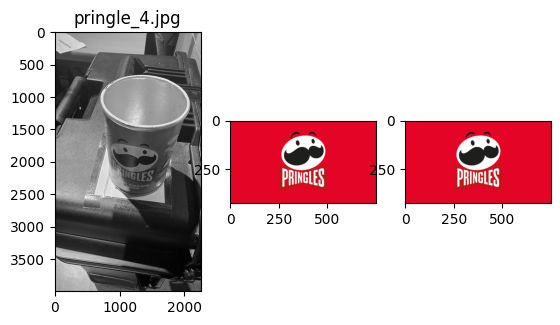

/var/folders/qc/p47pk0895gqf_sgg3vgy46g40000gn/T/ipykernel_53917/2311969795.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['class'] = submission['Predicted']


tensor([[0.0127, 0.0130, 0.0130, 0.0127, 0.0108, 0.0108, 0.0107, 0.0110, 0.0138,
         0.0139, 0.0140, 0.0137, 0.0147, 0.0141, 0.0138, 0.0137, 0.0127, 0.0127,
         0.0125, 0.0126, 0.0114, 0.0115, 0.0118, 0.0117, 0.0136, 0.0134, 0.0134,
         0.0135, 0.0113, 0.0114, 0.0114, 0.0116, 0.0144, 0.0144, 0.0144, 0.0150,
         0.0182, 0.0179, 0.0178, 0.0181, 0.0146, 0.0147, 0.0147, 0.0144, 0.0143,
         0.0147, 0.0147, 0.0146, 0.0119, 0.0119, 0.0122, 0.0123, 0.0132, 0.0133,
         0.0132, 0.0130, 0.0133, 0.0133, 0.0131, 0.0131, 0.0112, 0.0117, 0.0115,
         0.0115, 0.0118, 0.0121, 0.0119, 0.0118, 0.0146, 0.0142, 0.0143, 0.0141,
         0.0114, 0.0114, 0.0113, 0.0115]])
tensor(0.0182)


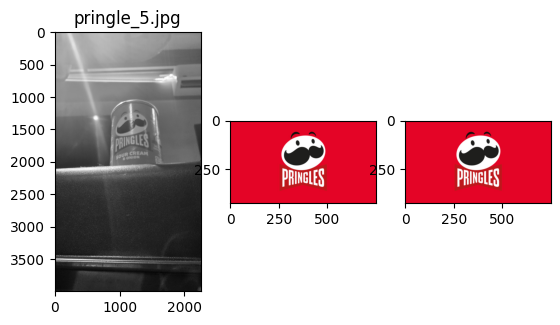

/var/folders/qc/p47pk0895gqf_sgg3vgy46g40000gn/T/ipykernel_53917/2311969795.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['class'] = submission['Predicted']


tensor([[0.0132, 0.0134, 0.0134, 0.0127, 0.0111, 0.0111, 0.0109, 0.0112, 0.0140,
         0.0140, 0.0140, 0.0135, 0.0152, 0.0145, 0.0139, 0.0136, 0.0121, 0.0121,
         0.0118, 0.0120, 0.0115, 0.0115, 0.0117, 0.0116, 0.0137, 0.0130, 0.0130,
         0.0129, 0.0117, 0.0118, 0.0118, 0.0118, 0.0140, 0.0136, 0.0136, 0.0141,
         0.0192, 0.0184, 0.0183, 0.0181, 0.0151, 0.0151, 0.0149, 0.0144, 0.0143,
         0.0146, 0.0146, 0.0143, 0.0117, 0.0117, 0.0119, 0.0119, 0.0129, 0.0129,
         0.0128, 0.0125, 0.0132, 0.0132, 0.0130, 0.0128, 0.0116, 0.0119, 0.0116,
         0.0115, 0.0127, 0.0128, 0.0123, 0.0120, 0.0149, 0.0143, 0.0143, 0.0140,
         0.0115, 0.0114, 0.0111, 0.0113]])
tensor(0.0192)


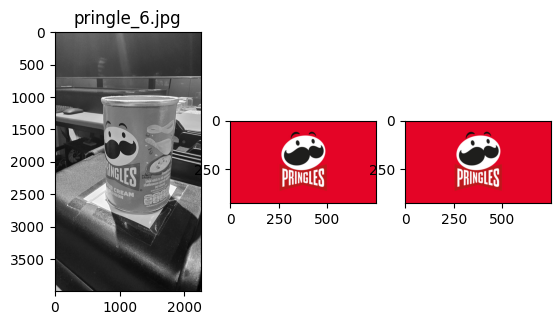

/var/folders/qc/p47pk0895gqf_sgg3vgy46g40000gn/T/ipykernel_53917/2311969795.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['class'] = submission['Predicted']


tensor([[0.0132, 0.0135, 0.0135, 0.0128, 0.0119, 0.0118, 0.0116, 0.0120, 0.0139,
         0.0139, 0.0139, 0.0134, 0.0149, 0.0144, 0.0139, 0.0135, 0.0128, 0.0128,
         0.0125, 0.0127, 0.0116, 0.0115, 0.0118, 0.0116, 0.0141, 0.0134, 0.0134,
         0.0134, 0.0114, 0.0116, 0.0116, 0.0116, 0.0144, 0.0140, 0.0140, 0.0144,
         0.0176, 0.0170, 0.0169, 0.0171, 0.0145, 0.0146, 0.0144, 0.0139, 0.0138,
         0.0141, 0.0141, 0.0138, 0.0120, 0.0121, 0.0123, 0.0123, 0.0129, 0.0129,
         0.0128, 0.0124, 0.0134, 0.0134, 0.0132, 0.0130, 0.0122, 0.0127, 0.0123,
         0.0122, 0.0127, 0.0129, 0.0123, 0.0122, 0.0141, 0.0135, 0.0135, 0.0132,
         0.0115, 0.0114, 0.0111, 0.0113]])
tensor(0.0176)


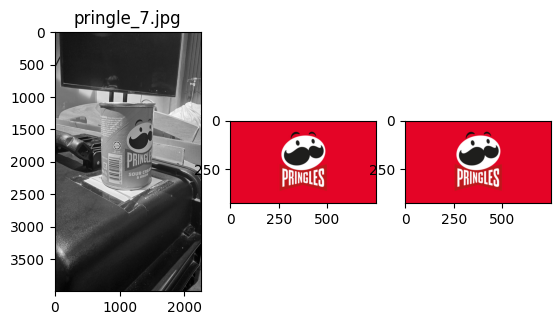

/var/folders/qc/p47pk0895gqf_sgg3vgy46g40000gn/T/ipykernel_53917/2311969795.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['class'] = submission['Predicted']


tensor([[0.0135, 0.0138, 0.0138, 0.0140, 0.0107, 0.0111, 0.0110, 0.0113, 0.0134,
         0.0140, 0.0141, 0.0143, 0.0130, 0.0131, 0.0134, 0.0135, 0.0124, 0.0124,
         0.0125, 0.0121, 0.0105, 0.0106, 0.0108, 0.0109, 0.0137, 0.0141, 0.0141,
         0.0137, 0.0109, 0.0110, 0.0110, 0.0112, 0.0172, 0.0178, 0.0178, 0.0177,
         0.0111, 0.0115, 0.0115, 0.0117, 0.0134, 0.0136, 0.0139, 0.0143, 0.0147,
         0.0150, 0.0150, 0.0151, 0.0138, 0.0139, 0.0141, 0.0143, 0.0144, 0.0149,
         0.0149, 0.0150, 0.0143, 0.0143, 0.0144, 0.0148, 0.0106, 0.0112, 0.0112,
         0.0110, 0.0110, 0.0116, 0.0120, 0.0118, 0.0143, 0.0151, 0.0151, 0.0150,
         0.0113, 0.0116, 0.0115, 0.0114]])
tensor(0.0178)


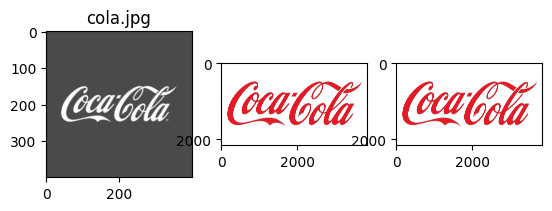

         img_file  class  dot_class    Predicted  cosine_class  \
0     scgc_1.jpeg      1          1         SCGC             1   
1     scgc_3.jpeg      1          1         SCGC             1   
2     scgc_7.jpeg      1          1         SCGC             1   
3     scgc_9.jpeg      1          1         SCGC             1   
4     scgp_3.jpeg      2          2         SCGP             2   
5     scgp_4.jpeg      2          2         SCGP             2   
6     scgp_5.jpeg      2          2         SCGP             2   
7     scgp_8.jpeg      2          2         SCGP             2   
8    scgp_12.jpeg      2         18    COCA COLA            18   
9    scgp_16.jpeg      2          2         SCGP             2   
10    wedo_3.jpeg      3          3         WEDO             3   
11    wedo_9.jpeg      3          3         WEDO             3   
12   wedo_10.jpeg      3          3         WEDO             3   
13   wedo_17.jpeg      3         18    COCA COLA            18   
14   amazo

/var/folders/qc/p47pk0895gqf_sgg3vgy46g40000gn/T/ipykernel_53917/2311969795.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['class'] = submission['Predicted']


In [7]:
# test images
submission['dot_class'] = 20
submission['cosine_class'] = 20
submission['minkowski_class'] = 20
submission['Predicted'] = 'None'
label ={1:'SCGC', 2:'SCGP',3:'WEDO',
        4:'PRINGLES',5:'HONDA',6:'LOUIS VUITTON',7:'APPMAN',
        8:'RIOT',9:'NIKE',10:'BMW',11:'FORD',12:'CAFE AMAZON',
        13:'MCDONALD',14:'KFC',15:'STARBUCKS',16:'BURGER KING',
        17:'DELL',18:'COCA COLA',19:'ADIDAS',20:'Undefind'}
with torch.no_grad():
    for idx, row in submission.iterrows():
        #print(row)
        # image = Image.open(os.path.join(src_dir, row['img_file'])).convert('RGB')
        # to grayscale
        image = Image.open(os.path.join(src_dir, row['img_file'])).convert('L')  # Convert to grayscale
        image = image.convert('RGB')  # Convert back to RGB by replicating channels

        # embedding
        inputs = preprocess(image).to(device)
        inputs = inputs.unsqueeze(0)
        outputs = model.encode_image(inputs).cpu()
        outputs = outputs / outputs.norm(p=2, dim=-1, keepdim=True)
        #print(outputs.softmax(1))
        # compute similarity with query
        #print(outputs.shape, q_embeddings.T.shape)
        values = outputs @ q_embeddings.T
        #values = outputs @ q_embeddings.T
        #print(values)
        #print(values.softmax(1))
        #print(values.softmax(1).max())
        thre_dot = 0.01 
        if values.softmax(1).max() > thre_dot:
            dot_class = query_classes[values.argmax().numpy().tolist()]
            submission.at[idx, 'dot_class'] = dot_class
            submission.at[idx, 'Predicted'] = label[dot_class]
        else:
            dot_class = 20

        cosine = torch.cosine_similarity(outputs, q_embeddings)
        #print(cosine)
        #print(cosine.max())
        thre_cosine = 0.1 #0.8
        if cosine.max() > thre_cosine:  #0.8
            cosine_class = query_classes[cosine.argmax().numpy().tolist()]
            submission.at[idx, 'cosine_class'] = cosine_class
        else:
            cosine_class = 20

        # # display result for 50 images
        if 0 <= idx < 50:
            plt.subplot(1,3,1)
            plt.title(row['img_file'])
            plt.imshow(image)
            plt.subplot(1,3,2)
            if dot_class != 20:
                plt.imshow(Image.open(os.path.join(query_dir, str(dot_class) + '.jpeg')))
            plt.subplot(1,3,3)
            if cosine_class != 20:
                plt.imshow(Image.open(os.path.join(query_dir, str(cosine_class) + '.jpeg')))
            plt.show()

        sub = submission[['img_file',]]
    #     sub['class'] = submission['dot_class']
    #     sub.to_csv(root + model_name + '-' + pretrained + '_dot_product_than'+ str(thre_dot).replace('.', '-') +'-aug04.csv', index=False)
        sub['class'] = submission['Predicted']
        sub.to_csv('for_submission.csv', index=False)
    print(submission)